# Import Library and Load data


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


![alt text](https://miro.medium.com/max/1000/1*ZKSTkWpJlGKIfYP9wDgz5w.jpeg)


In [30]:
import pickle
import os
import pandas as pd
import numpy as np
from matplotlib import rc, pyplot as plt 
import seaborn as sns
sns.set()
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
#from tensorflow import SparseTensor
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate, Embedding, Reshape, Dot, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.math import exp
from tensorflow.keras.initializers import he_normal, RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import round as KerasRound
from tensorflow.keras.models import load_model
font = {'weight': 'bold', 'size': 15}
rc('font', **font); rc("figure", facecolor="white"); rc('axes', edgecolor='darkgray')

PATH='/content/gdrive/My Drive/RecommendationSystem'
DATA_PATH='/content/gdrive/My Drive/RecommendationSystem/datasets'
MF_WEIGHT_PATH = '/content/gdrive/My Drive/RecommendationSystem/mf_weights'
DL_WEIGHT_PATH = '/content/gdrive/My Drive/RecommendationSystem/dl_weights'
MF_MODEL_PATH = '/content/gdrive/My Drive/RecommendationSystem/mf_weights/my_mf_model'
DL_MODEL_PATH = '/content/gdrive/My Drive/RecommendationSystem/dl_weights/my_dl_model'

In [3]:
def split_dataframe(df, test_size):
  test = df.sample(frac=test_size, replace=False, random_state=1612)
  train = df[~df.index.isin(test.index)]
  return train, test

def plot_heatmap(model):
  user_embedding = model.get_layer(name='user_embedding').get_weights()[0]
  movie_embedding = model.get_layer(name='movie_embedding').get_weights()[0]
  result = user_embedding @ movie_embedding.T
  plt.figure(figsize=(20,10))
  sns.heatmap(result, cmap='Greens')
  plt.show()

def plot_loss(history):
  plt.figure(figsize=(20,10))
  plt.plot(history.history['loss'] , 'b')
  plt.plot(history.history['val_loss'] , 'orange')
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid(True)
  plt.show()

In [4]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.user'), sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.data'), sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.item'), sep='|', names=movies_cols, encoding='latin-1')
movies = movies.drop(columns=['video_release_date'])
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

print('User df shape:', users.shape)
print('Movie df shape:', movies.shape)
print('Rating df shape:', ratings.shape)

User df shape: (943, 5)
Movie df shape: (1682, 24)
Rating df shape: (100000, 4)


In [5]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [6]:
movies.head()

,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995


In [7]:
ratings.head()

#embedding user = (n_user, k)

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


Đổi cột id từ Object sang int và train_test_split

In [8]:
ratings.user_id = ratings.user_id.astype('category').cat.codes.values #id columns are object, parse to int
ratings.movie_id = ratings.movie_id.astype('category').cat.codes.values
movies.movie_id = movies.movie_id.astype('category').cat.codes.values
users.user_id = users.user_id.astype('category').cat.codes.values

train_df, val_df = split_dataframe(ratings, test_size=0.4)
val_df, test_df = split_dataframe(val_df, test_size=0.5)
train_df.shape, val_df.shape, test_df.shape

((60000, 4), (20000, 4), (20000, 4))

Plot phân bố điểm

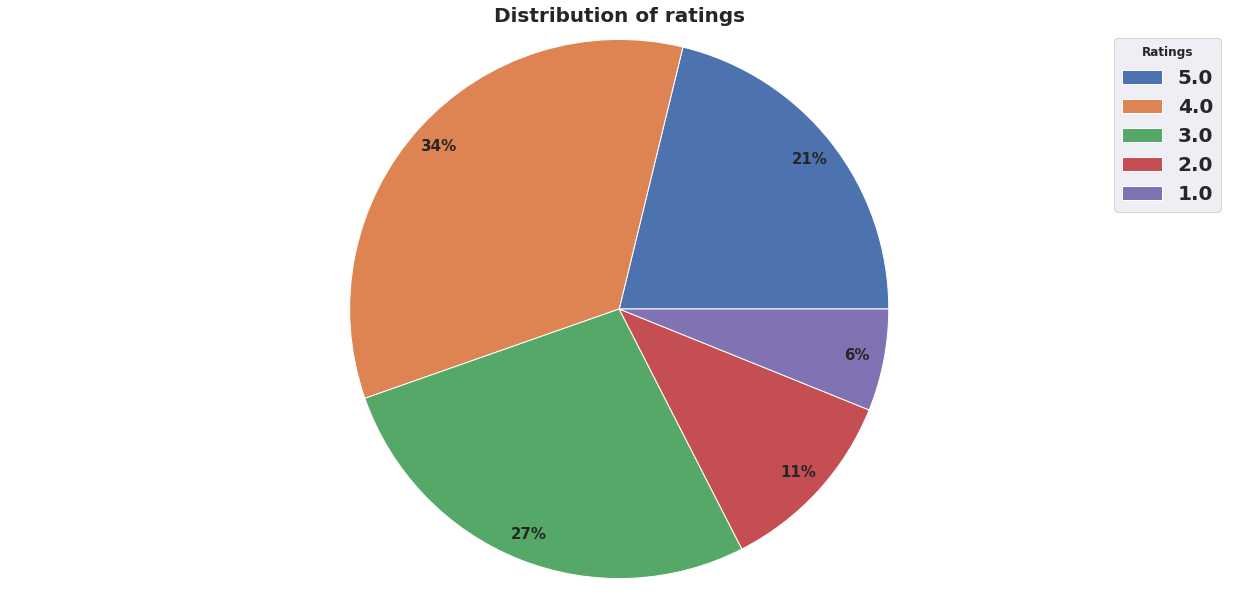

In [9]:
data = ratings['rating'].value_counts().sort_index(ascending=False)
data.head()

plt.figure(figsize=(20,10))
plt.gca().axis("equal")
pie = plt.pie(data, startangle=0, autopct='%1.0f%%', pctdistance=0.9, radius=1.2,)
labels=data.index.unique()
plt.title('Distribution of ratings', weight='bold', size=20)
plt.legend(pie[0],labels, loc="best", fontsize=20, 
           bbox_transform=plt.gcf().transFigure,title='Ratings')
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)

plt.show()
plt.clf()
plt.close()

# Matrix Factorisation (MF)


In [10]:
n_latent=12
n_movies=len(movies['movie_id'].values)
n_users=len(users['user_id'].values)
L2_DECAY = 1e-8
LR = 0.001
LR_DECAY = 0.1
LR_STEP = 20
EPOCHS_PATIENCE = 20
BATCH_SIZE = 128



def scheduler(epoch, lr):
  if epoch % LR_STEP == 0 and epoch:
    return lr * LR_DECAY
  return lr

def create_mf_model():
  user_input = Input(shape=(1,), dtype='int64')
  user_embedding = Embedding(n_users, n_latent,name='user_embedding', 
                             embeddings_initializer=RandomNormal(seed=16),
                             embeddings_regularizer=l2(L2_DECAY))(user_input)
  user_vec = Flatten()(user_embedding) # from shape (1,latent) to (latent)

  movie_input = Input(shape=(1,), dtype='int64')
  movie_embedding = Embedding(n_movies, n_latent,name='movie_embedding',
                              embeddings_initializer=RandomNormal(seed=17),
                              embeddings_regularizer=l2(L2_DECAY))(movie_input)
  movie_vec = Flatten()(movie_embedding)
 
  dot = Dot(axes=(1), normalize=False)([user_vec, movie_vec])
  #out = KerasRound(dot)
  model = Model([user_input, movie_input], dot)
  return model



In [11]:
mf_model = create_mf_model()
mf_model.summary()
mf_model.compile(loss='mse', optimizer=Adam(LR))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 12)        11316       input_1[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 12)        20184       input_2[0][0]                    
______________________________________________________________________________________________

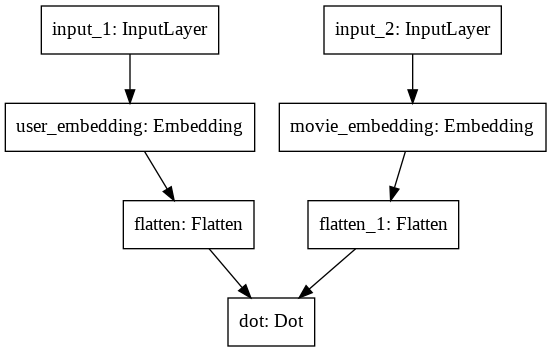

In [12]:

plot_model(mf_model, os.path.join(PATH,'mf.png'))


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=EPOCHS_PATIENCE, restore_best_weights=True)
lr_decay = LearningRateScheduler(scheduler)

mf_history = mf_model.fit([train_df.user_id, train_df.movie_id],
          train_df.rating,
          batch_size=BATCH_SIZE, 
          epochs=200,
          callbacks=[early_stop, lr_decay],
          validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

# mf_history = mf_model.fit([train_df.user_id, train_df.movie_id],
#           train_df.rating,
#           batch_size=128, 
#           epochs=200,
#           callbacks=[early_stop],
#           validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

mf_model.save_weights(os.path.join(MF_WEIGHT_PATH, 'mf_weight'))
mf_model.save(os.path.join(MF_WEIGHT_PATH, 'my_mf_model'))


Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


469/469 [==============================] - 1s 2ms/step - loss: 13.7118 - val_loss: 13.6522 - lr: 0.0010
Epoch 2/200
469/469 [==============================] - 1s 2ms/step - loss: 12.1706 - val_loss: 9.4776 - lr: 0.0010
Epoch 3/200
469/469 [==============================] - 1s 2ms/step - loss: 5.8432 - val_loss: 3.2517 - lr: 0.0010
Epoch 4/200
469/469 [==============================] - 1s 2ms/step - loss: 2.2648 - val_loss: 1.7736 - lr: 0.0010
Epoch 5/200
469/469 [==============================] - 1s 2ms/step - loss: 1.4504 - val_loss: 1.3361 - lr: 0.0010
Epoch 6/200
469/469 [==============================] - 1s 2ms/step - loss: 1.1569 - val_loss: 1.1472 - lr: 0.0010
Epoch 7/200
469/469 [==============================] - 1s 2ms/step - loss: 1.0196 - val_loss: 1.0514 - lr: 0.0010
Epoch 8/200
469/469 [==============================] - 1s 2ms/step - loss: 0.9455 - val_loss: 0.9997 - lr: 0.0010
Epoch 9/200
469/469 [==============================] - 1s 2ms/step - loss: 0.9018 - val_loss: 0.9

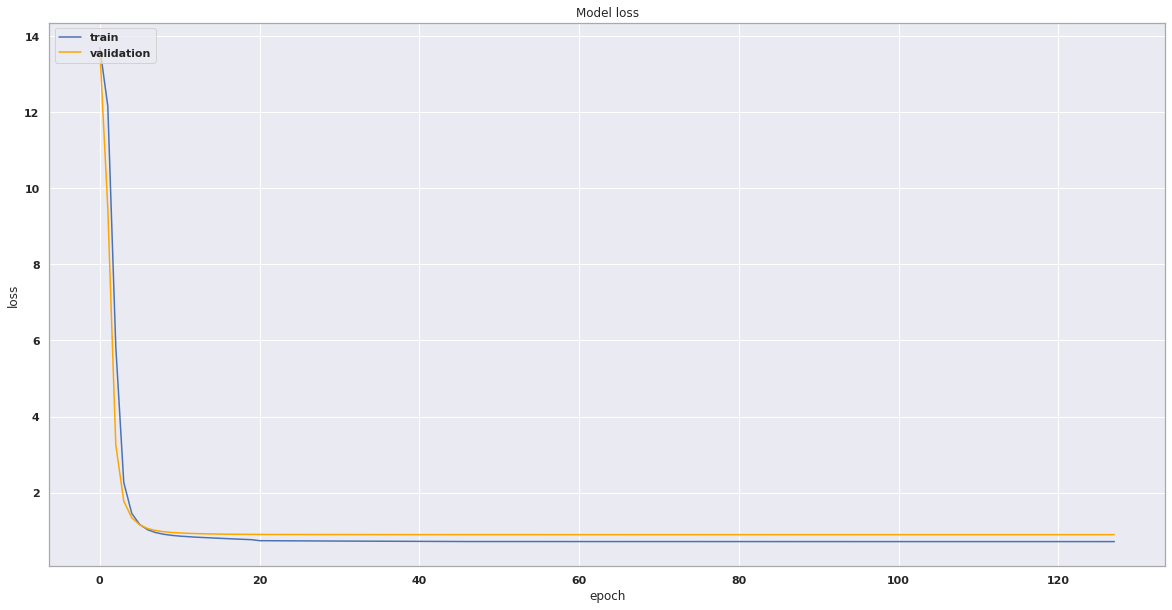

In [14]:
plot_loss(mf_history)

In [15]:
mf_model.evaluate([test_df.user_id, test_df.movie_id], test_df.rating)

625/625 [==============================] - 1s 1ms/step - loss: 0.9028


0.9028329253196716

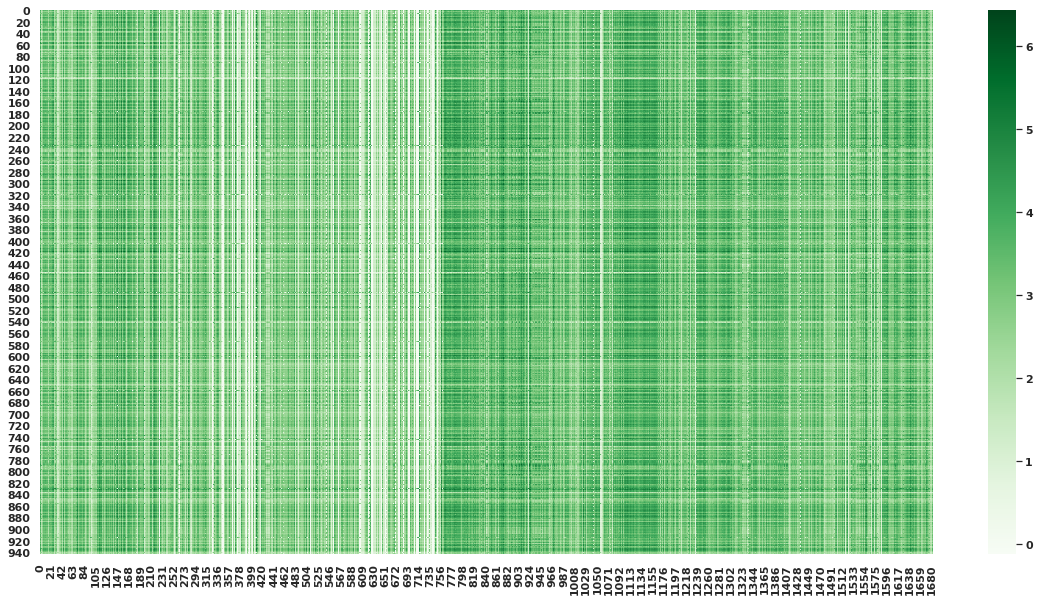

In [16]:
plot_heatmap(mf_model)

# Neural Collaborative Filtering (NCF)

In [17]:
DL_N_LATENTS=50
DL_L2_DECAY = 1e-8
DL_LR = 0.001
DL_LR_DECAY = 0.1
DL_LR_STEP = 10
DL_EPOCHS_PATIENCE = 20
DL_BATCH_SIZE = 128
DL_DROPOUT = 0.3

def dl_scheduler(epoch, lr):
  # if epoch % LR_STEP == 0 and epoch:
  #   return lr * LR_DECAY
  # return lr
  return lr

def create_deep_learning_model():
  user_input = Input(shape=(1,), dtype='int64')
  user_embedding = Embedding(n_users, DL_N_LATENTS,name='user_embedding', 
                             embeddings_initializer=RandomNormal(seed=16),
                             embeddings_regularizer=l2(DL_L2_DECAY))(user_input)
  user_vec = Flatten()(user_embedding)
  user_vec=Dropout(0.3)(user_vec)

  movie_input = Input(shape=(1,), dtype='int64')
  movie_embedding = Embedding(n_movies, DL_N_LATENTS,name='movie_embedding',
                              embeddings_initializer=RandomNormal(seed=17),
                              embeddings_regularizer=l2(DL_L2_DECAY))(movie_input)
  movie_vec = Flatten()(movie_embedding)
  movie_vec=Dropout(0.3)(movie_vec)

 # dot = Dot(1, normalize=False)([user_vec, movie_vec])
  dot = Concatenate()([user_vec, movie_vec])

  dense=Dense(128,activation='relu', kernel_initializer=he_normal(seed=16), 
              kernel_regularizer=l2(DL_L2_DECAY),)(dot)
  dense=BatchNormalization()(dense)
  dense=Dropout(0.3)(dense)
  dense=Dense(128,activation='relu',kernel_initializer=he_normal(seed=16), 
              kernel_regularizer=l2(DL_L2_DECAY))(dense)
  dense=BatchNormalization()(dense)
  dense=Dropout(0.3)(dense)
  out=Dense(1,activation='relu',)(dense)

  model = Model([user_input, movie_input], out)
  return model

In [18]:
dl_model = create_deep_learning_model()
dl_model.summary()
dl_model.compile(loss='mse', optimizer=Adam(DL_LR))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        47150       input_3[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        84100       input_4[0][0]                    
____________________________________________________________________________________________

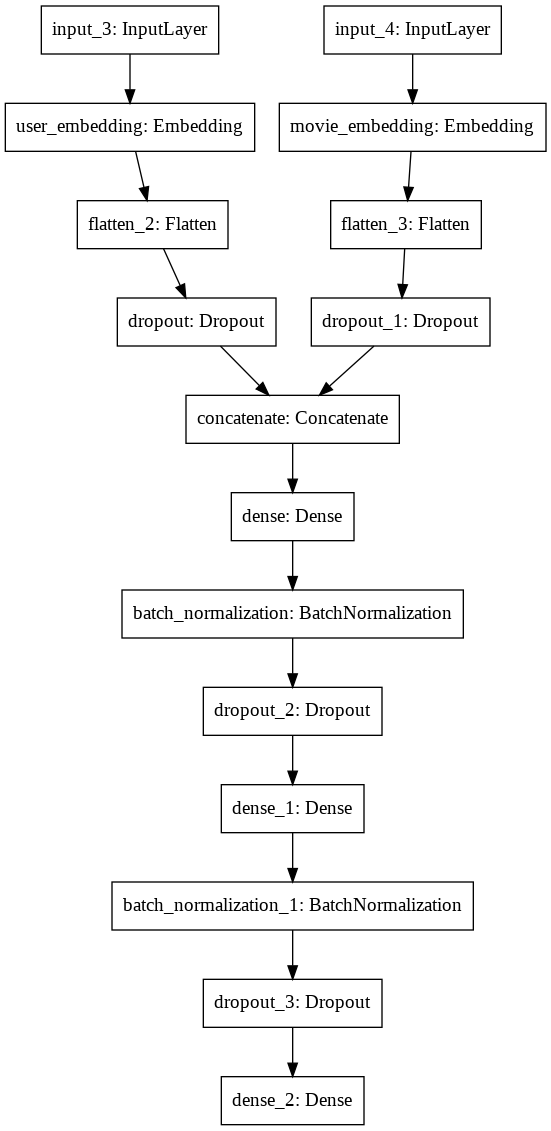

In [19]:
plot_model(dl_model, os.path.join(PATH,'dl.png'))

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=DL_EPOCHS_PATIENCE, restore_best_weights=True)
lr_decay = LearningRateScheduler(dl_scheduler)

dl_history = dl_model.fit([train_df.user_id, train_df.movie_id],
          train_df.rating,
          batch_size=DL_BATCH_SIZE, 
          epochs=200,
          callbacks=[early_stop, lr_decay],
          validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))


dl_model.save_weights(os.path.join(DL_WEIGHT_PATH, 'dl_weights'))
dl_model.save(os.path.join(DL_WEIGHT_PATH, 'my_dl_model'))

Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


469/469 [==============================] - 2s 5ms/step - loss: 3.8982 - val_loss: 1.2474 - lr: 0.0010
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 1.5077 - val_loss: 1.1778 - lr: 0.0010
Epoch 3/200
469/469 [==============================] - 2s 5ms/step - loss: 1.2461 - val_loss: 1.0245 - lr: 0.0010
Epoch 4/200
469/469 [==============================] - 2s 5ms/step - loss: 1.1292 - val_loss: 0.9822 - lr: 0.0010
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 1.0582 - val_loss: 0.9612 - lr: 0.0010
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 1.0111 - val_loss: 0.9371 - lr: 0.0010
Epoch 7/200
469/469 [==============================] - 2s 5ms/step - loss: 0.9836 - val_loss: 0.9319 - lr: 0.0010
Epoch 8/200
469/469 [==============================] - 2s 5ms/step - loss: 0.9537 - val_loss: 0.9290 - lr: 0.0010
Epoch 9/200
469/469 [==============================] - 2s 5ms/step - loss: 0.9389 - val_loss: 0.9279

In [21]:
dl_model.evaluate([test_df.user_id, test_df.movie_id],test_df.rating)

625/625 [==============================] - 1s 2ms/step - loss: 0.8863


0.8863350749015808

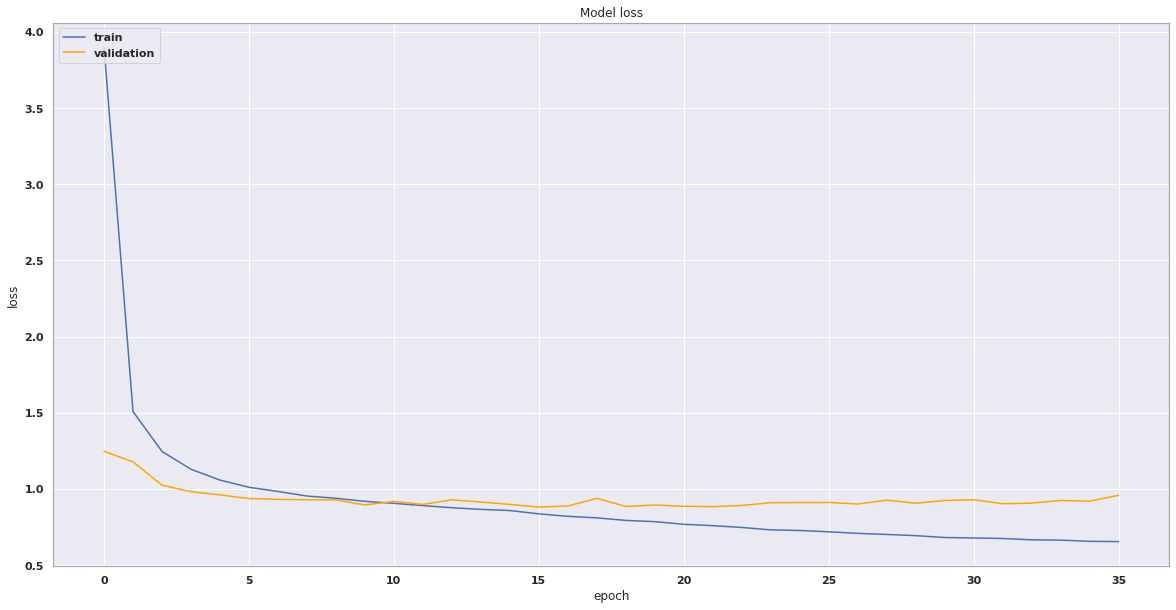

In [22]:
plot_loss(dl_history)

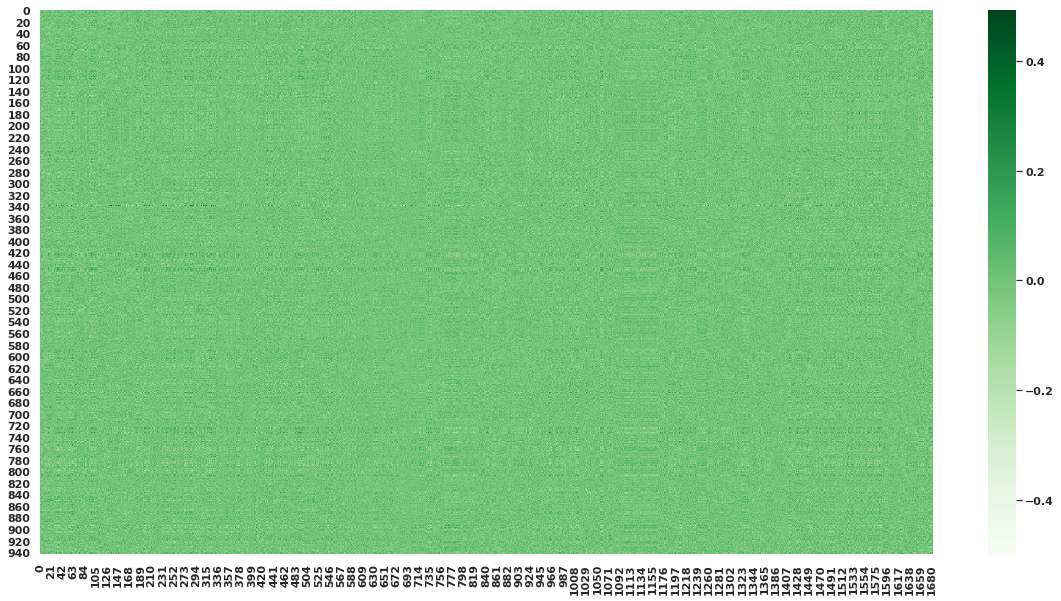

In [23]:
plot_heatmap(dl_model)

# Recommend movies

In [24]:
def recommend(model, user_id, number_of_movies=5):
  user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
  movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]
  result = user_embedding_learnt[user_id]@movie_embedding_learnt.T
  indexs = np.argsort(result)
  display(movies.loc[movies['movie_id'].isin(indexs[-number_of_movies:])])
  

In [25]:
print('5 movies for user 195 from mf_model')
recommend(mf_model, 195)
print('5 movies for user 195 from dl_model')
recommend(dl_model, 195)

5 movies for user 195 from mf_model


,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
49,1116,Star Wars (1977),01-Jan-1977,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1977
271,874,Good Will Hunting (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1997
301,908,L.A. Confidential (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1997
312,920,Titanic (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1997
1448,500,Pather Panchali (1955),22-Mar-1996,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1996


5 movies for user 195 from dl_model


,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
121,236,"Cable Guy, The (1996)",14-Jun-1996,"http://us.imdb.com/M/title-exact?Cable%20Guy,%...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996
374,988,Showgirls (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Showgirls%20(...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
423,1043,Children of the Corn: The Gathering (1996),01-Jan-1996,http://us.imdb.com/M/title-exact?Children%20of...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1996
1411,460,Land Before Time III: The Time of the Great Gi...,01-Jan-1995,http://us.imdb.com/M/title-exact?Land%20Before...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1485,541,Girl in the Cadillac (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Girl%20in%20t...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995


# Load pretrained models




Mount GG-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import các library cần thiết

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
from matplotlib import rc, pyplot as plt 
import seaborn as sns
sns.set()
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
#from tensorflow import SparseTensor
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate, Embedding, Reshape, Dot, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.math import exp
from tensorflow.keras.initializers import he_normal, RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import round as KerasRound
from tensorflow.keras.models import load_model
font = {'weight': 'bold', 'size': 15}
rc('font', **font); rc("figure", facecolor="white"); rc('axes', edgecolor='darkgray')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import các hàm cần thiết

In [3]:
def split_dataframe(df, test_size):
  test = df.sample(frac=test_size, replace=False, random_state=1612)
  train = df[~df.index.isin(test.index)]
  return train, test

Thay đổi đường dẫn tới các file sau cho phù hợp với drive của bạn


1.   DATA_PATH = Đường dẫn tới thư mục dataset
2.   MF_MODEL_PATH = Đường dẫn tới thư mục mf_model
3. DL_MODEL_PATH = Đường dẫn tới thư mục dl_model



In [4]:
DATA_PATH = '/content/gdrive/My Drive/....'
MF_MODEL_PATH = '/content/gdrive/My Drive/....'
DL_MODEL_PATH = '/content/gdrive/My Drive/....'

Chạy cell này để load dataset và train_test_split

In [5]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.user'), sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.data'), sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.item'), sep='|', names=movies_cols, encoding='latin-1')
movies = movies.drop(columns=['video_release_date'])
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

print('User df shape:', users.shape)
print('Movie df shape:', movies.shape)
print('Rating df shape:', ratings.shape)

ratings.user_id = ratings.user_id.astype('category').cat.codes.values #id columns are object, parse to int
ratings.movie_id = ratings.movie_id.astype('category').cat.codes.values
movies.movie_id = movies.movie_id.astype('category').cat.codes.values
users.user_id = users.user_id.astype('category').cat.codes.values

train_df, val_df = split_dataframe(ratings, test_size=0.4)
val_df, test_df = split_dataframe(val_df, test_size=0.5)
print('Train_df shape:', train_df.shape)
print('Val_df shape:', val_df.shape)
print('Test_df shape:', test_df.shape)

User df shape: (943, 5)
Movie df shape: (1682, 24)
Rating df shape: (100000, 4)
Train_df shape: (60000, 4)
Val_df shape: (20000, 4)
Test_df shape: (20000, 4)


Load Matrix Factorisation Model (mf_model)

In [6]:
mf_model = load_model(MF_MODEL_PATH)
mf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 12)        11316       input_1[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 12)        20184       input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
mf_model.evaluate([test_df.user_id, test_df.movie_id], test_df.rating)

625/625 [==============================] - 1s 1ms/step - loss: 0.9028


0.9028329253196716

Lấy Embeddings của User và Movie

In [8]:
mf_user_embedding = mf_model.get_layer(name='user_embedding').get_weights()[0]
mf_movie_embedding = mf_model.get_layer(name='movie_embedding').get_weights()[0]

Load Neural Collaborative Filtering Model (dl_model)

In [9]:
dl_model = load_model(DL_MODEL_PATH)
dl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        47150       input_3[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        84100       input_4[0][0]                    
____________________________________________________________________________________________

In [10]:
dl_model.evaluate([test_df.user_id, test_df.movie_id], test_df.rating)

625/625 [==============================] - 1s 1ms/step - loss: 0.8863


0.8863350749015808

Lấy Embeddings của User và Movie

In [11]:
dl_user_embedding = dl_model.get_layer(name='user_embedding').get_weights()[0]
dl_movie_embedding = dl_model.get_layer(name='movie_embedding').get_weights()[0]

Xem các phần phía trên của notebook để biết quá trình làm bài